# Main_Quest(폐렴)

## 개요
X-ray 폐렴 사진을 학습시켜서 전체적인 모델의 성능을 개선시키는 작업을 하였다. CNN 모델이 base model이었다. 정확도를 개선하기 위해서 데이터 증강, base model의 변경 및 모델 구조의 변경을 시도하였다. ResNet은 정확도에서 base model에 비해서 개선된 결과를 보였다.

## Summary
* base model은 약 82% 이상의 정확도를 보였고, 정밀도도 약 79%였다. 재현율도 98.5%여서 높은 수치를 보였다. 좌우를 바꾼 데이터 증강을 반영한 모델은 손실 값이 오히려 약 0.6에서 약 1.1로 증가했고, 정확도도 약 78%로 떨어졌다. 다만, 재현율은 소폭 개선되었기 때문에 실제 양성을 더 잡아냈다는 것을 의미한다. 1x1 필터를 적용한 modified model은 손실 값은 base model보다 개선되었으나, 정확도, 정밀도 및 재현율은 개선된 부분은 없었다. ResNet-18은 정확도가 84.5%로 가장 높은 수치를 보였고, 정밀도는 81.5%였다.

| 모델 | Loss | Accuracy | Precision | Recall | 비고 |
|:---: |:---: |:---: |:---: |:---: |:---: |
| base model | 0.601 | 0.827 | 0.790 | 0.985 | - |
| data augm. | 1.139 | 0.784 | 0.744 | 0.997 | - |
| modified model | 0.514 | 0.819 | 0.788 | 0.972 | - |
| ResNet | 0.669 | 0.845 | 0.815 | 0.972 | - |


## 목차
1. base model
2. 데이터 증강 기법 적용
3. 모델 구조 변경
4. ResNet 모델 구현
5. 회고
6. reference


## 1. base model

In [6]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.keras.backend.clear_session()
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
# ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel') # 로컬 실행을 위해서 삭제함
TRAIN_PATH = 'chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = 'chest_xray/data/val/*/*'
TEST_PATH = 'chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

#  print(ROOT_PATH)

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
chest_xray/data/train/NORMAL/NORMAL2-IM-1110-0001.jpeg
Pneumonia image path
chest_xray/data/train/PNEUMONIA/person393_virus_784.jpeg


In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

2024-06-21 22:19:50.265355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:19:50.265832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:19:50.266119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:19:50.472343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:19:50.472638: I external/local_xla/xla/stream_executor

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

2024-06-21 22:20:08.471687: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


624


In [17]:
# # 데이터 증강시에는 미실행함

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

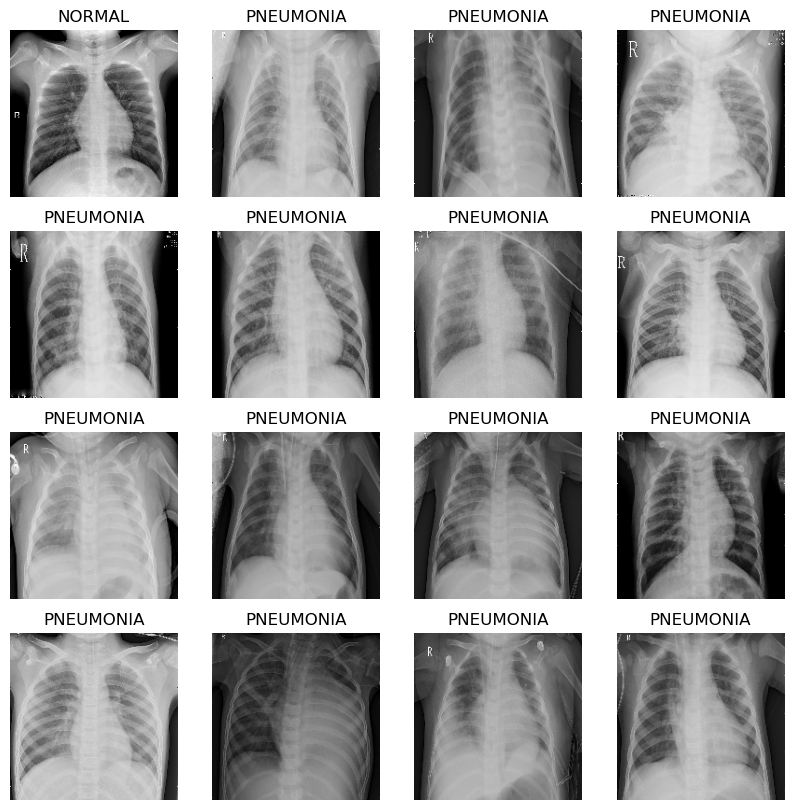

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [108]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [109]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [22]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [21]:
# data가 tf.bool 타입으로 입력되면 오류가 발생해서 float32 타입으로 변경

train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10


2024-06-21 12:32:36.808437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-21 12:32:44.105179: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-21 12:32:44.369088: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-21 12:32:46.176799: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb61c188940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 12:32:46.176842: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-21 12:32:46.209841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash repr

261/261 [==============================] - 55s 145ms/step - loss: 0.3837 - accuracy: 0.8084 - precision: 0.9608 - recall: 0.7740 - val_loss: 0.6137 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 40s 153ms/step - loss: 0.2360 - accuracy: 0.9085 - precision: 0.9726 - recall: 0.9025 - val_loss: 1.2221 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 49s 187ms/step - loss: 0.1951 - accuracy: 0.9289 - precision: 0.9769 - recall: 0.9263 - val_loss: 0.0875 - val_accuracy: 0.9644 - val_precision: 0.9827 - val_recall: 0.9686
Epoch 4/10
261/261 [==============================] - 36s 137ms/step - loss: 0.1662 - accuracy: 0.9346 - precision: 0.9810 - recall: 0.9301 - val_loss: 0.1248 - val_accuracy: 0.9471 - val_precision: 0.9437 - val_recall: 0.9869
Epoch 5/10
261/261 [==============================] - 34s 130ms/step - loss: 0.1739 - accuracy: 0.9346 

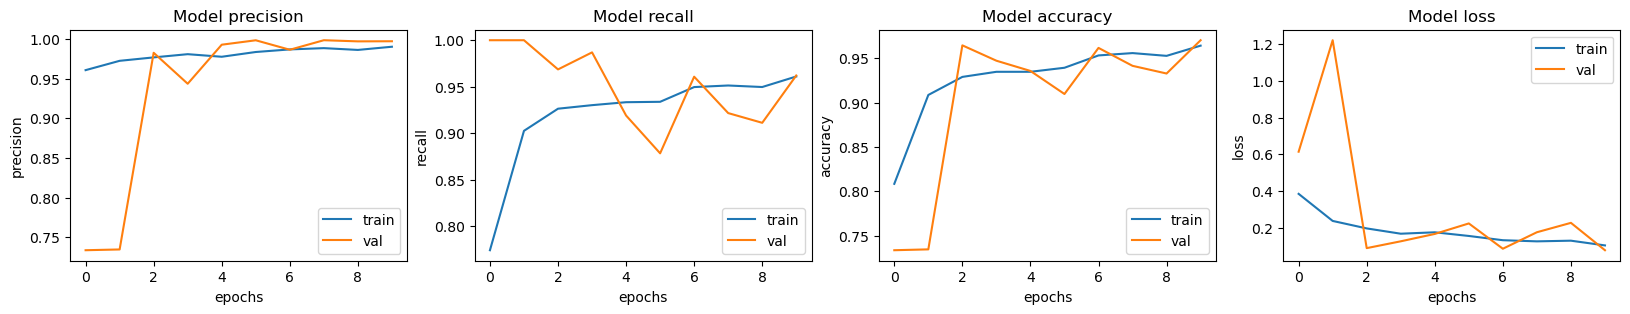

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 89ms/step - loss: 0.6009 - accuracy: 0.8269 - precision: 0.7901 - recall: 0.9846
Loss: 0.6008704304695129,
Accuracy: 0.8269230723381042,
Precision: 0.790123462677002,
Recall: 0.9846153855323792


## 2. 데이터 증강 기법 적용

In [19]:
# 데이터 증강: 랜덤 좌우 변경
# → 4차원 데이터 타입이 되어야 하는데, 5차원이 되는 문제가 발생함. 새롭게 데이터를 셋팅해서 prepare_for_training()을 한 번만 적용하여 해결

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [121]:

print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


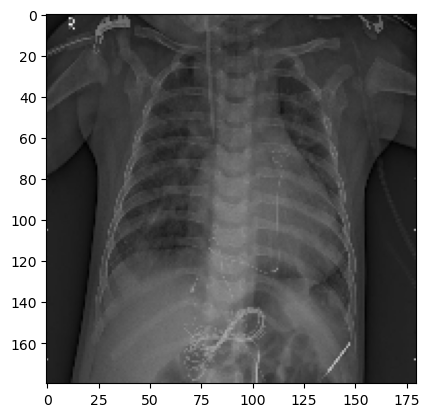

In [135]:
# 실습환경에서 제시하는 방법으로는 show_batch() 인데, 오류가 발생해서 imshow()로 확인함
plt.imshow(image_batch[1]) # 좌우 이미지가 잘 바뀌었음

In [119]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 40s 132ms/step - loss: 0.0851 - accuracy: 0.9715 - precision: 0.9927 - recall: 0.9688 - val_loss: 0.0596 - val_accuracy: 0.9798 - val_precision: 0.9895 - val_recall: 0.9830
Epoch 2/10
261/261 [==============================] - 34s 131ms/step - loss: 0.0916 - accuracy: 0.9660 - precision: 0.9930 - recall: 0.9610 - val_loss: 0.3370 - val_accuracy: 0.8885 - val_precision: 1.0000 - val_recall: 0.8480
Epoch 3/10
261/261 [==============================] - 34s 132ms/step - loss: 0.0803 - accuracy: 0.9686 - precision: 0.9927 - recall: 0.9649 - val_loss: 0.1447 - val_accuracy: 0.9481 - val_precision: 0.9972 - val_recall: 0.9319
Epoch 4/10
261/261 [==============================] - 35s 134ms/step - loss: 0.0876 - accuracy: 0.9691 - precision: 0.9921 - recall: 0.9662 - val_loss: 0.0666 - val_accuracy: 0.9721 - val_precision: 0.9986 - val_recall: 0.9634
Epoch 5/10
261/261 [==============================] - 34s 132ms/step - loss: 0.0694 - accura

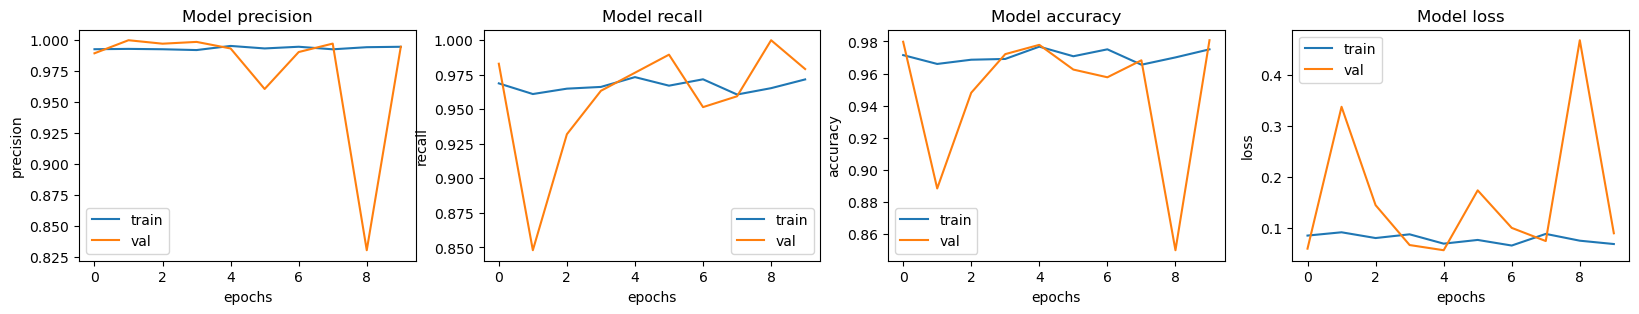

In [120]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [121]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 87ms/step - loss: 1.1387 - accuracy: 0.7837 - precision: 0.7438 - recall: 0.9974
Loss: 1.1387325525283813,
Accuracy: 0.7836538553237915,
Precision: 0.7437858581542969,
Recall: 0.9974358677864075


## 3. 모델 구조 변경

In [22]:
# 1 x 1 filter 삽입

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Conv2D(128, 1, activation='relu', padding='same'), # 1 x 1 filter를 넣어서 channel을 다시 줄여서 연산량을 감소시킴
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 45, 45, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       27072     
                                                      

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10


2024-06-21 16:19:06.996944: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-21 16:19:13.005796: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-21 16:19:14.088702: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-21 16:19:15.822363: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1ef4155fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 16:19:15.822428: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-21 16:19:15.838358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash r

261/261 [==============================] - 49s 125ms/step - loss: 0.4161 - accuracy: 0.8020 - precision: 0.9464 - recall: 0.7780 - val_loss: 0.7620 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 33s 125ms/step - loss: 0.2353 - accuracy: 0.9100 - precision: 0.9713 - recall: 0.9057 - val_loss: 1.6775 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 32s 124ms/step - loss: 0.1981 - accuracy: 0.9267 - precision: 0.9749 - recall: 0.9253 - val_loss: 0.1148 - val_accuracy: 0.9558 - val_precision: 0.9532 - val_recall: 0.9882
Epoch 4/10
261/261 [==============================] - 33s 125ms/step - loss: 0.1708 - accuracy: 0.9349 - precision: 0.9797 - recall: 0.9319 - val_loss: 0.0900 - val_accuracy: 0.9683 - val_precision: 0.9703 - val_recall: 0.9869
Epoch 5/10
261/261 [==============================] - 33s 126ms/step - loss: 0.1591 - accuracy: 0.9380 

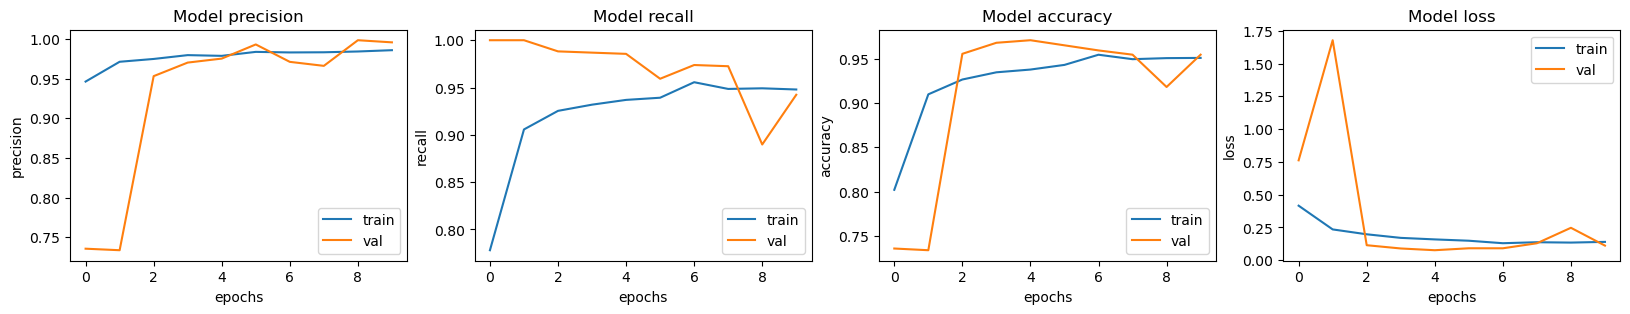

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 91ms/step - loss: 0.5141 - accuracy: 0.8189 - precision: 0.7879 - recall: 0.9718
Loss: 0.5141118764877319,
Accuracy: 0.8189102411270142,
Precision: 0.7879418134689331,
Recall: 0.971794843673706


## 4. ResNet 구현

In [58]:
# 1차 시도: residual connection이 없어서 그런듯...

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def residual_block(filters, kernel_size, stride):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, activation='relu', padding='same'),        
        tf.keras.layers.BatchNormalization(),
  
    ])
    
    return block

def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, activation='relu', padding='same'),

        tf.keras.layers.MaxPool2D(3, strides=2, padding='same'),
        residual_block(64, 3, 2),
        residual_block(64, 3, 2),
        
        residual_block(128, 3, 2),
        residual_block(128, 3, 2),
        
        residual_block(256, 3, 2),
        residual_block(256, 3, 2),

        residual_block(512, 3, 2),
        residual_block(512, 3, 2),

        tf.keras.layers.AveragePooling2D(7, strides=1, padding='same'), 
        
        tf.keras.layers.Flatten(),
        dense_block(1000),        
        
        tf.keras.layers.Dense(1, activation='softmax'),
    ])
    
    return model

In [ ]:
# Identity Block
# class IdentityBlock(tf.keras.Model):
#     def __init__(self, filters, kernel_size):
#         super(IdentityBlock, self).__init__(name='')
 
#         self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
#         self.bn1 = tf.keras.layers.BatchNormalization()
 
#         self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
#         self.bn2 = tf.keras.layers.BatchNormalization()
 
#         self.relu = tf.keras.layers.Activation('relu')
#         self.add = tf.keras.layers.Add()
    
#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)
 
#         x = self.conv2(x)
#         x = self.bn2(x)
 
#         x = self.add([x, inputs])
#         x = self.relu(x)
 
#         return x

# class ResNet(tf.keras.Model):
#     def __init__(self, num_classes):
#         super(ResNet, self).__init__()
#         self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
#         self.bn = tf.keras.layers.BatchNormalization()
#         self.relu = tf.keras.layers.Activation('relu')
#         self.max_pool = tf.keras.layers.MaxPool2D((3, 3))
#         self.id1a = IdentityBlock(64, 3)
#         self.id1b = IdentityBlock(64, 3)
#         self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
#         self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
    
#     def call(self, inputs):
#         x = self.conv(inputs)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.max_pool(x)
 
#         x = self.id1a(x)
#         x = self.id1b(x)
 
#         x = self.global_pool(x)
#         return model

# model = ResNet()
# model.summary()

In [59]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
model.summary()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210 (Conv2D)         (None, 90, 90, 64)        9472      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 sequential_136 (Sequential  (None, 12, 12, 64)        74368     
 )                                                               
                                                                 
 sequential_137 (Sequential  (None, 3, 3, 64)          74368     
 )                                                               
                                                                 
 sequential_138 (Sequential  (None, 1, 1, 128)         222464    
 )                                                  

In [60]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [61]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10


261/261 [==============================] - 65s 170ms/step - loss: 0.5634 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 0.5866 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 41s 157ms/step - loss: 0.3388 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 0.3094 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 49s 189ms/step - loss: 0.2734 - accuracy: 0.7455 - precision: 0.7455 - recall: 1.0000 - val_loss: 0.1808 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 51s 195ms/step - loss: 0.2413 - accuracy: 0.7433 - precision: 0.7433 - recall: 1.0000 - val_loss: 1.0105 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 42s 161ms/step - loss: 0.2566 - accuracy: 0.7445 

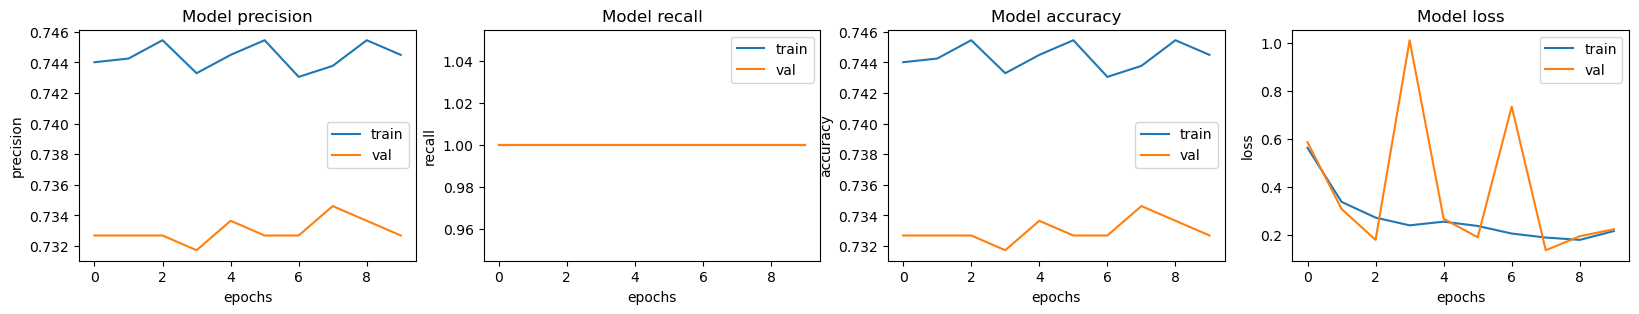

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 0.4683 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.4682541489601135,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [1]:
# ResNet 2차 시도
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import time

from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K
import random
from keras.preprocessing.image import ImageDataGenerator

import random
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.keras.backend.clear_session()
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-06-21 22:19:06.001821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 22:19:06.001887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 22:19:06.066222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 22:19:06.199521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 22:19:07.502167: W tensorflow/compiler/tf2

In [23]:
def resnet_block(inputs,kernel,filters,strides=1,activation='relu'):
    x=Conv2D(filters,kernel_size=(kernel,kernel),strides=strides, padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation(activation)(x)
    x=Conv2D(filters,kernel_size=(kernel,kernel), padding='same')(x)
    x=BatchNormalization()(x)
    if strides != 1 or inputs.shape[3] != filters:
       inputs = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)
    x=Add()([inputs,x])
    x=Activation(activation)(x)
    return x

In [24]:
def resnet_18(input_shape):
    inputs=Input(shape=input_shape)
    x=Conv2D(64,kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    x=MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,128,strides=2)
    x=resnet_block(x,3,128)
    x=resnet_block(x,3,256,strides=2)
    x=resnet_block(x,3,256)
    x=resnet_block(x,3,512,strides=2)
    x=resnet_block(x,3,512)
    x=AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='same')(x)
    x=Flatten()(x)
    x=Dense(1,activation='sigmoid')(x)
    model=Model(inputs=inputs,outputs=x)
    return model

In [25]:
input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

with tf.device('/GPU:0'):
    model = resnet_18(input_shape)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 90, 90, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 90, 90, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 90, 90, 64)           0         ['batch_normalization[0][0

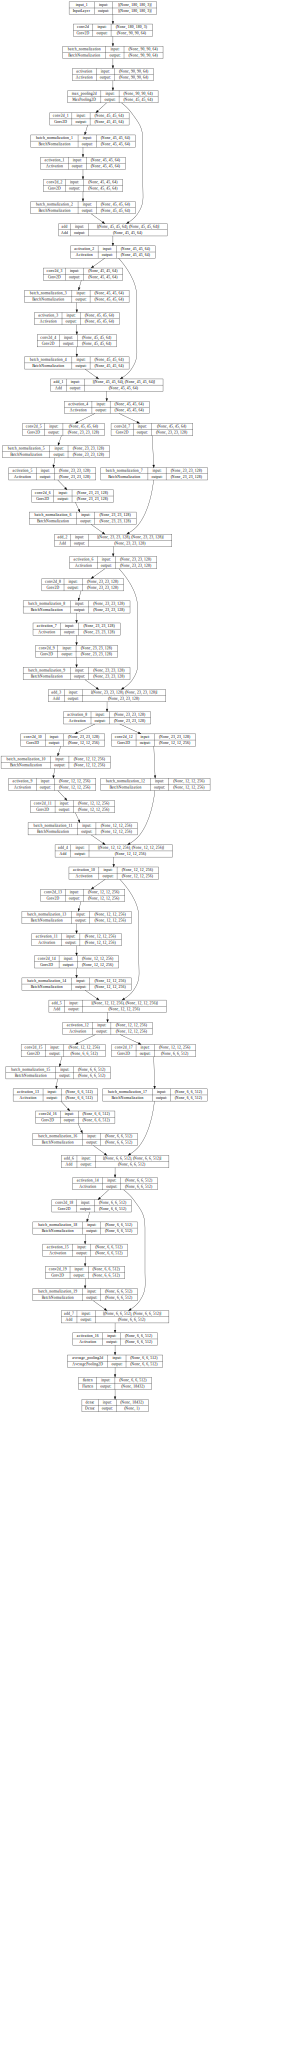

In [26]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=50).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10


2024-06-21 22:21:38.137953: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-21 22:21:39.516442: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-21 22:21:42.052900: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f10ab09f120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 22:21:42.052949: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-21 22:21:42.071169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718976102.181270    1850 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 [==============================] - 64s 158ms/step - loss: 0.5416 - accuracy: 0.8508 - precision: 0.9445 - recall: 0.8493 - val_loss: 16.9422 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 39s 150ms/step - loss: 0.2542 - accuracy: 0.9066 - precision: 0.9683 - recall: 0.9041 - val_loss: 0.4414 - val_accuracy: 0.7702 - val_precision: 0.7628 - val_recall: 0.9974
Epoch 3/10
261/261 [==============================] - 48s 186ms/step - loss: 0.1936 - accuracy: 0.9270 - precision: 0.9762 - recall: 0.9244 - val_loss: 0.2953 - val_accuracy: 0.8962 - val_precision: 0.9545 - val_recall: 0.9022
Epoch 4/10
261/261 [==============================] - 40s 151ms/step - loss: 0.1576 - accuracy: 0.9399 - precision: 0.9811 - recall: 0.9372 - val_loss: 0.3158 - val_accuracy: 0.8375 - val_precision: 0.8223 - val_recall: 0.9935
Epoch 5/10
261/261 [==============================] - 39s 150ms/step - loss: 0.1364 - accuracy: 0.9468

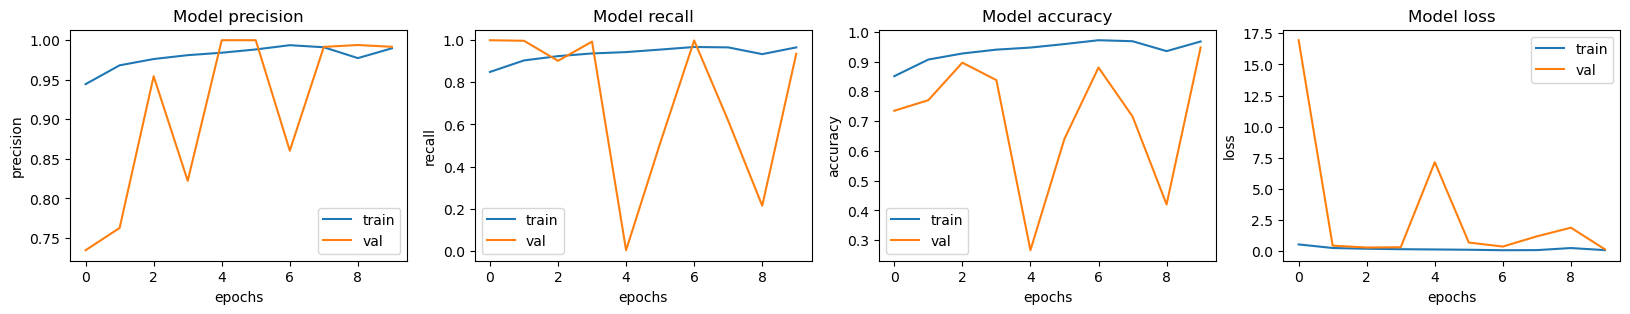

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 105ms/step - loss: 0.6690 - accuracy: 0.8446 - precision: 0.8151 - recall: 0.9718
Loss: 0.6689591407775879,
Accuracy: 0.8445512652397156,
Precision: 0.8150537610054016,
Recall: 0.971794843673706


## 5. 회고
* ResNet을 구현하는 데에 있어서 Residual Connection 구조를 적용하는 데에 많은 어려움을 겪었다. Sequential 구조를 그대로 유지한 채로 Residual Connection을 구현하는 것이 불가능했기 때문이다. 함수 호출 방식으로 이를 구현하여 해결하였다. 한편, sigmoid를 softmax로 변환하는 것은 해결하지 못한 부분이다. input 값 자체의 category가 주어지지 않았고, 폴더의 위치를 통해서 True와 False 값을 가지기 때문에 핫코딩을 해야할 것으로 판단했으나, 그 부분은 추후에 보완하는 것으로 할 예정이다.

## 6. reference
* ResNet-18 구현 참고: https://velog.io/@stilltravel/AI-ResNet-18-Layer
